# DIS21a 1 | Big Data | Exam WS 2022/23 | Group J (10)

## Participants

-   [Markus Hardtke](https://elearning.iws.th-koeln.de/moodle/user/profile.php?id=2705)
    -   Matriculation Number: 1234567
-   [Furkan Erdogan](https://elearning.iws.th-koeln.de/moodle/user/profile.php?id=2688)
    -   Matriculation Number: 1234567
-   [Jannik Loose](https://elearning.iws.th-koeln.de/moodle/user/profile.php?id=2687)
    -   Matriculation Number: 1234567
-   [Gilles Romer](https://elearning.iws.th-koeln.de/moodle/user/profile.php?id=2681)
    -   Matriculation Number: 11139919

---

## Project Setup

*This Setup was made for Windows users and will differ if you are using a different OS.    
The recommended Python version used to run this notebook is 3.9.13*

1. Virtual environment

    *This step is required so you can install the required packages without affecting or filling up your global Python installation.*

    ```bash
    python3 -m venv .venv
    source .venv/Scripts/activate
    pip install -r requirements.txt
    ```

2. Git

    *This step is required so unnecessary data from the Notebook is not pushed to the repository. This will automatically remove all metadata and execution counts from the Notebook as soon as you stage your file.*

    1. Download JQ (flexible command-line JSON processor) from [here](https://github.com/stedolan/jq/releases/download/jq-1.6/jq-win64.exe)
    2. Create the following Folder: `C:\Program Files\jq`
    3. Add the following line to your PATH environment variable: `C:\Program Files\jq`
    4. Rename the downloaded JQ file to `jq.exe` and move it to the previously created folder
    5. Add the following lines to your .gitconfig file (usually found in C:\Users\YOUR_USERNAME\.gitconfig)

        ```bash
        [core]
            attributesfile = ~/.gitattributes_global
        [filter "nbstrip_meta"]
            clean = "jq --indent 4 \
                    '(.cells[] | select(has(\"execution_count\")) | .execution_count) = null  \
                    | .metadata = {\"language_info\": {\"name\": \"python\", \"pygments_lexer\": \"ipython3\"}} \
                    | .cells[].metadata = {} \
                    '"
            smudge = cat
            required = true
        [filter "nbstrip_full"]
            clean = "jq --indent 4 \
                    '(.cells[] | select(has(\"outputs\")) | .outputs) = []  \
                    | (.cells[] | select(has(\"execution_count\")) | .execution_count) = null  \
                    | .metadata = {\"language_info\": {\"name\": \"python\", \"pygments_lexer\": \"ipython3\"}} \
                    | .cells[].metadata = {} \
                    '"
            smudge = cat
            required = true
        ```

    6. Create a `.gitattributes_global` file at the same location as your `.gitconfig` file and add the following lines:

        ```bash
        *.ipynb filter=nbstrip_meta
        ```

3. Weights and Biases

    *Weights and Biases is a tool that helps you track your experiments and visualize your results. It is also used to run hyperparameter sweeps.*  
    
    Make sure to create an account on [Weights and Biases](https://wandb.ai/site) and accept the invitation to the Team.  
    Furthermore you will have to add your [API key](https://wandb.ai/settings#dangerzone) to the [scrts.py](./scrts.py) file under `wandb_api_key`.

## Optional Setup

1. Tensorflow GPU support  

    *<span style="color:orange">This step is optional and only required if you want to use a GPU for training.</span>*  
   Follow this setup to activate tensorflow GPU support (Make sure to install the mentioned versions rather than the latest one!): [https://www.tensorflow.org/install/gpu](https://www.tensorflow.org/install/gpu)  
   This tutorial will additionally help you to install CUDA and cuDNN: [https://lifewithdata.com/2022/01/16/how-to-install-tensorflow-and-keras-with-gpu-support-on-windows/](https://lifewithdata.com/2022/01/16/how-to-install-tensorflow-and-keras-with-gpu-support-on-windows/) 

---


## Environment Setup

### Path's

In [ ]:
# Importing the necessary libraries
import os
import sys

# Setting up the path to the root of the repository
path = os.getcwd()
notebookpath = os.path.join(path, 'Exam_WS2223.ipynb')

datapath = os.path.join(path, 'data')
data_testpath = os.path.join(datapath, 'seg_test')
data_trainpath = os.path.join(datapath, 'seg_train')
data_valpath = os.path.join(datapath, 'seg_pred')

### Tensorflow version and GPU availability

In [ ]:
# Importing the libraries
import tensorflow as tf
from tensorflow import keras

# Checking versions and gpu availability
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# Setting up the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


Tensorflow version: 2.10.0
Keras Version: 2.10.0
GPU is available
1 Physical GPUs, 1 Logical GPUs


### Wandb

In [ ]:
# Importing the libraries
import wandb
import scrts
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import logging
import absl.logging
import os

# Removing all unnecessary logs
# absl.logging.set_verbosity(absl.logging.ERROR)
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
os.environ['WANDB_SILENT'] = 'true'
os.environ['WANDB_CONSOLE'] = 'off'
os.environ['WANDB_NOTEBOOK_NAME'] = notebookpath
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

if scrts.wandb_api_key is None:
    print("Please enter your wandb API key in scrts.py")
else:
    wandb.login(key=scrts.wandb_api_key)
# wandb.init(project="Exam", entity="dis21a1_ws22-21_gruppe10")

---
## What are we working with?

### What does the data look like?

In [ ]:
from PIL import Image
from PIL.ExifTags import TAGS

# Show metadata of images and folders

# Training data
data_train_length = sum([len(files) for r, d, files in os.walk(data_trainpath)])
# Check if all training images have the same dimensions
for folder in os.listdir(data_trainpath):
    for i, image in enumerate(os.listdir(os.path.join(data_trainpath, folder))):
        if i == 0:
            data_train_imgsize_heigt = Image.open(os.path.join(data_trainpath, folder, image)).height
            data_train_imgsize_width = Image.open(os.path.join(data_trainpath, folder, image)).width
        else:
            if data_train_imgsize_heigt != Image.open(os.path.join(data_trainpath, folder, image)).height or data_train_imgsize_width != Image.open(os.path.join(data_trainpath, folder, image)).width:
                print(f"The train image {folder}/{image} has different dimensions than the others")
                break
print(f"The training data contains {sum([len(files) for r, d, files in os.walk(data_trainpath)])} images with the dimensions {data_train_imgsize_heigt}x{data_train_imgsize_width} pixels")

# Test data
data_val_length = sum([len(files) for r, d, files in os.walk(data_valpath)])
# Check if all test images have the same dimensions
for folder in os.listdir(data_testpath):
    for i, image in enumerate(os.listdir(os.path.join(data_testpath, folder))):
        if i == 0:
            data_test_imgsize_heigt = Image.open(os.path.join(data_testpath, folder, image)).height
            data_test_imgsize_width = Image.open(os.path.join(data_testpath, folder, image)).width
        else:
            if data_test_imgsize_heigt != Image.open(os.path.join(data_testpath, folder, image)).height or data_test_imgsize_width != Image.open(os.path.join(data_testpath, folder, image)).width:
                print(f"The test image {folder}/{image} has different dimensions than the others")
                break
print(f"The test data contains {sum([len(files) for r, d, files in os.walk(data_testpath)])} images with the dimensions {data_test_imgsize_heigt}x{data_test_imgsize_width} pixels")

# Validation data
data_val_length = sum([len(files) for r, d, files in os.walk(data_valpath)])
# Check if all validation images have the same dimensions
for i, image in enumerate(os.listdir(data_valpath)):
    if i == 0:
        data_val_imgsize_heigt = Image.open(os.path.join(data_valpath, image)).height
        data_val_imgsize_width = Image.open(os.path.join(data_valpath, image)).width
    else:
        if data_val_imgsize_heigt != Image.open(os.path.join(data_valpath, image)) or data_val_imgsize_width != Image.open(os.path.join(data_valpath, image)):
            print(f"The validation image {image} has different dimensions than the others")
            break
print(f"The validation data contains {sum([len(files) for r, d, files in os.walk(data_valpath)])} images with the dimensions {data_val_imgsize_heigt}x{data_val_imgsize_width} pixels")

The train image buildings/5358.jpg has different dimensions than the others
The train image forest/1004.jpg has different dimensions than the others
The train image glacier/1010.jpg has different dimensions than the others
The train image mountain/11873.jpg has different dimensions than the others
The train image sea/19551.jpg has different dimensions than the others
The train image street/13747.jpg has different dimensions than the others
The training data contains 14034 images with the dimensions 150x150 pixels
The test image forest/22014.jpg has different dimensions than the others
The test image glacier/21274.jpg has different dimensions than the others
The test image mountain/22117.jpg has different dimensions than the others
The test data contains 3000 images with the dimensions 150x150 pixels
The validation image 10005.jpg has different dimensions than the others
The validation data contains 7301 images with the dimensions 150x150 pixels


General image size = 150x150

### Loading and normalizing the data

In [ ]:
import random
import numpy as np
classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
def load_data(datapath, classes):
    # Only load training and test data
    for dataset in os.listdir(datapath):
        if dataset == "seg_train" or dataset == "seg_test":
            # Load the images
            images = []
            for folder in os.listdir(os.path.join(datapath, dataset)):
                for image in os.listdir(os.path.join(datapath, dataset, folder)):
                    # resize images to 150x150
                    img = Image.open(os.path.join(datapath, dataset, folder, image))
                    img = img.resize((150, 150))
                    images.append([img, folder])
            # Shuffle the images
            random.shuffle(images)
            # Split the images into data(the actual image) and labels
            data = []
            labels = []
            for image in images:
                data.append(image[0])
                labels.append(image[1])
            if dataset == "seg_train":
                train_data = data
                train_labels = labels
            else:
                test_data = data
                test_labels = labels
    return train_data, train_labels, test_data, test_labels

train_data, train_labels, test_data, test_labels = load_data(datapath, classes)

### Normalizing the data

In [ ]:
# Vectorizing the labels
def label_vectorization(labels):
    # Convert the labels to numbers
    for i, label in enumerate(labels):
        labels[i] = classes.index(label)
    # One-hot encoding the labels
    from tensorflow.keras.utils import to_categorical
    labels = to_categorical(labels, num_classes=len(classes))
    return labels

train_labels = label_vectorization(train_labels)
test_labels = label_vectorization(test_labels)

# Normalizing the images
def image_normalization(data):
    # Convert the images to arrays
    for i, image in enumerate(data):
        data[i] = np.array(image, dtype="float32")
    # Normalize the images
    data = np.array(data) / 255
    return data

train_data = image_normalization(train_data)
test_data = image_normalization(test_data)

### Checking dataset structure again

The training data contains 14034 images with the dimensions (150, 150, 3) pixels
The test data contains 3000 images with the dimensions (150, 150, 3) pixels


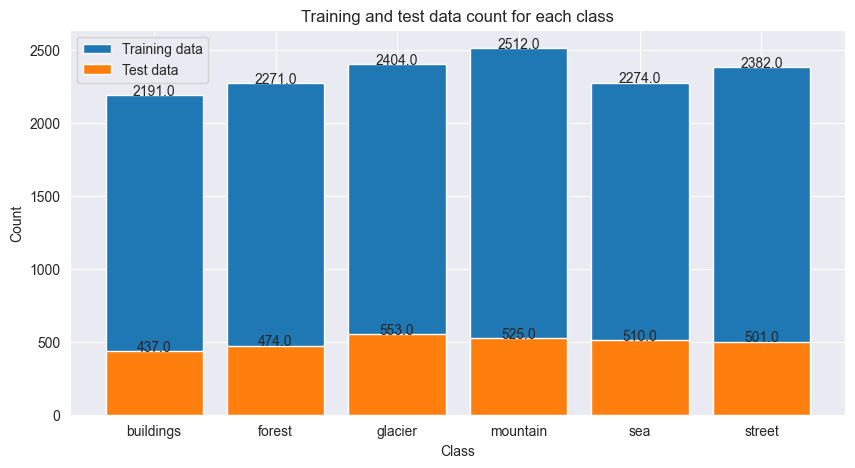

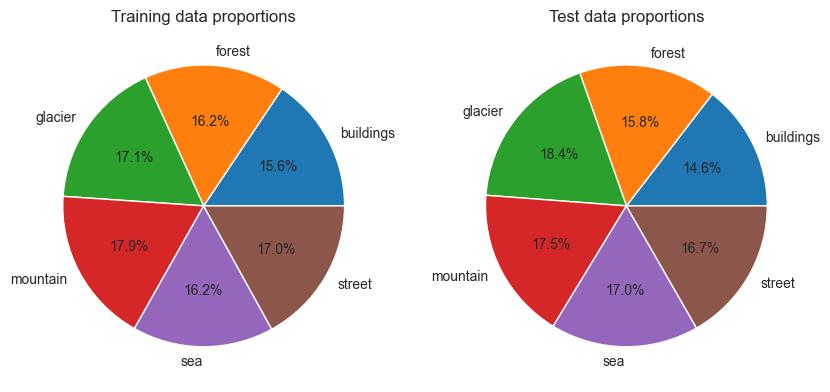

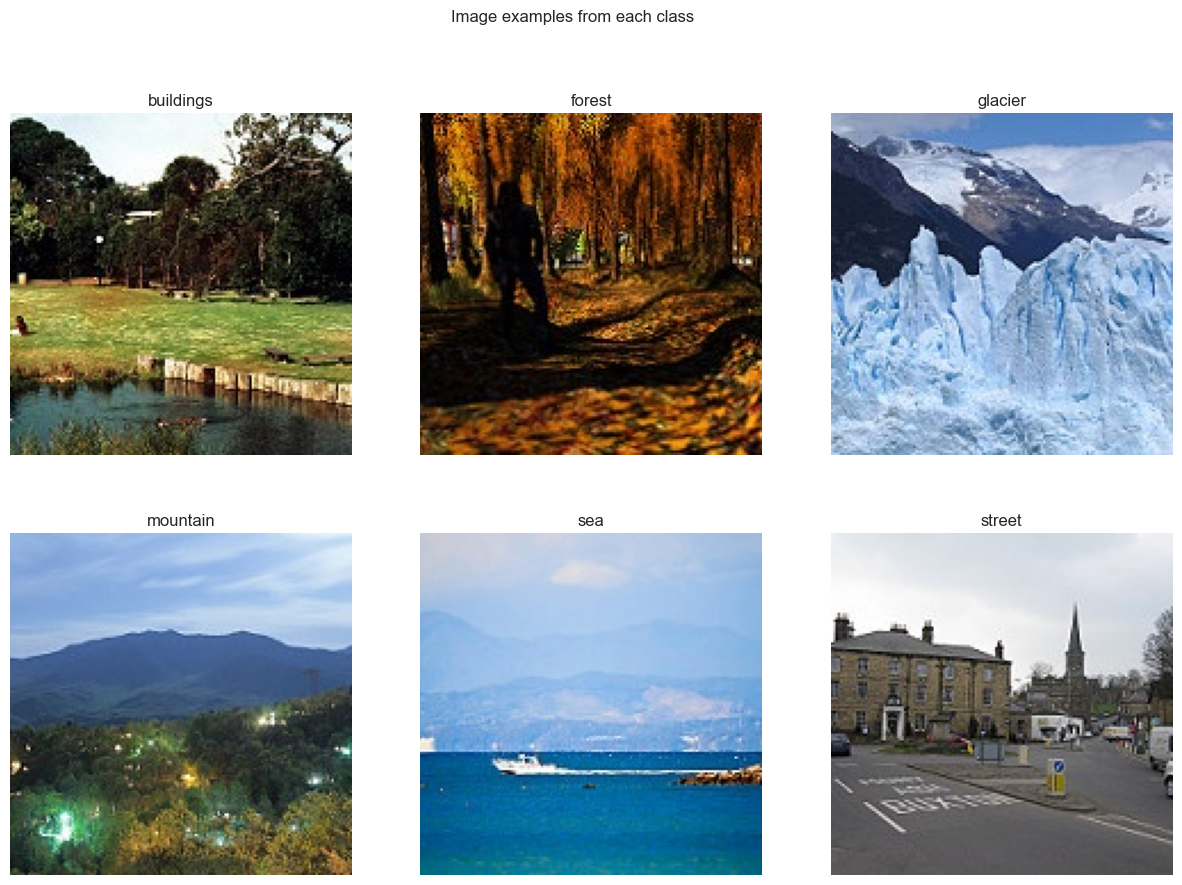

In [ ]:
# Checking the dimensions of the data
print(f"The training data contains {len(train_data)} images with the dimensions {train_data[0].shape} pixels")
print(f"The test data contains {len(test_data)} images with the dimensions {test_data[0].shape} pixels")

# Showing training and test data count for each class
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize=(10, 5))
plt.title("Training and test data count for each class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.bar(classes, [train_labels[:, i].sum() for i in range(len(classes))], label="Training data")
plt.bar(classes, [test_labels[:, i].sum() for i in range(len(classes))], label="Test data")
for i in range(len(classes)):
    plt.text(x=classes[i], y=train_labels[:, i].sum(), s=train_labels[:, i].sum(), ha="center")
    plt.text(x=classes[i], y=test_labels[:, i].sum(), s=test_labels[:, i].sum(), ha="center")
plt.legend()
plt.show()

# Showing the proportion each class has in the training and test data in a pie chart
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training data proportions")
plt.pie([train_labels[:, i].sum() for i in range(len(classes))], labels=classes, autopct="%1.1f%%")
plt.subplot(1, 2, 2)
plt.title("Test data proportions")
plt.pie([test_labels[:, i].sum() for i in range(len(classes))], labels=classes, autopct="%1.1f%%")
plt.show()

# Showing 5 random images from each class
plt.figure(figsize=(15, 10))
plt.suptitle("Image examples from each class")
for i in range(len(classes)):
    plt.subplot(2, 3, i + 1)
    plt.title(classes[i])
    plt.axis("off")
    plt.imshow(train_data[np.random.choice(np.where(train_labels[:, i] == 1)[0])])
plt.show()

---
## Building the model

In [ ]:
# defining wandb settings to run on non-pretrained model
sweep_config = {
        'method': 'bayes',
        'metric': {
                'name': 'val_acc',
                'goal': 'maximize'
        },
        'parameters': {
                'epochs': {
                        'values': [10, 20]
                },
                'batch_size': {
                        'values': [32, 64, 128, 256]
                },
                'optimizer': {
                        'values': ['adam', 'rmsprop']
                },
                'layers': {
                        'values': [
                                [32, 64, 128, 128],
                                [32, 64, 64, 128],
                                [32, 64, 128]
                        ]
                }
        }
}

In [ ]:
# Importing the necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# model builder
def build_model(optimizer, layers=[32, 64, 128, 128], dropout=0.5, input_shape=(150, 150, 3)):
    model = Sequential()

    for i, layer in enumerate(layers):
        if i == 0:
            model.add(Conv2D(layer, (3, 3), activation="relu", input_shape=input_shape))
            model.add(MaxPooling2D((2, 2)))
        else:
            model.add(Conv2D(layer, (3, 3), activation="relu"))
            model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(len(classes), activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model

# model training
def train_model(model, batch_size, epochs, log_freq=10, train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels):
    tf.keras.backend.clear_session()
    # callback setup
    wandb_callbacks = [
            WandbMetricsLogger(log_freq=log_freq),
            # WandbModelCheckpoint(filepath="my_model_{epoch:02d}")
    ]
    history = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_data, test_labels), callbacks=wandb_callbacks)
    return history

In [ ]:
def sweep_train(config_defaults=None):
        # Initialize wandb with a sample project name
        with wandb.init(config=config_defaults):  # this gets over-written in the Sweep

                # Specify the other hyperparameters to the configuration, if any
                wandb.config.architecture_name = "Environments"
                wandb.config.dataset_name = "data"

                # initialize model
                model = build_model(
                        wandb.config.optimizer,
                        wandb.config.layers
                )

                train_model(
                        model,
                        wandb.config.batch_size,
                        wandb.config.epochs
                )
sweep_id = wandb.sweep(sweep_config, project="Exam", entity="dis21a1_ws22-21_gruppe10")
wandb.agent(sweep_id, function=sweep_train, count=20)

Create sweep with ID: aisqto4e
Sweep URL: https://wandb.ai/dis21a1_ws22-21_gruppe10/Exam/sweeps/aisqto4e
Epoch 1/20
220/220 [==============================] - 17s 61ms/step - loss: 1.2148 - accuracy: 0.5252 - val_loss: 0.9052 - val_accuracy: 0.6537
Epoch 2/20
220/220 [==============================] - 12s 56ms/step - loss: 0.8228 - accuracy: 0.6889 - val_loss: 0.8490 - val_accuracy: 0.6603
Epoch 3/20
220/220 [==============================] - 12s 56ms/step - loss: 0.6876 - accuracy: 0.7444 - val_loss: 0.8102 - val_accuracy: 0.7010
Epoch 4/20
220/220 [==============================] - 12s 56ms/step - loss: 0.5952 - accuracy: 0.7807 - val_loss: 0.9766 - val_accuracy: 0.6627
Epoch 5/20
220/220 [==============================] - 12s 55ms/step - loss: 0.5438 - accuracy: 0.8047 - val_loss: 0.6390 - val_accuracy: 0.7853
Epoch 6/20
220/220 [==============================] - 12s 56ms/step - loss: 0.4863 - accuracy: 0.8211 - val_loss: 0.5415 - val_accuracy: 0.8203
Epoch 7/20
220/220 [===========

Run ajbqjbnj errored: InternalError()
Run 9c5slmm8 errored: InternalError()
Run 0h4d1ocw errored: InternalError()
Run s9nihv5h errored: InternalError()


In [ ]:
batch_size = 32
training_size = len(train_data)
validation_size = len(test_data)

steps_per_epoch = training_size // batch_size
validation_steps = validation_size // batch_size

print("steps_per_epoch=",steps_per_epoch)
print("validation_steps=",validation_steps)

In [ ]:
# defining wandb settings to run on pretrained model
sweep_config_Resnet = {
        'method': 'bayes',
        'metric': {
                'name': 'val_acc',
                'goal': 'maximize'
        },
        'parameters': {
                'epochs': {
                        'values': [5, 10]
                },
                'batch_size': {
                        'value': batch_size
                }
        }
}

In [ ]:
from tensorflow.keras.applications import ResNet50
def build_Resnet_model():
    model = Sequential()

    base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    model.add(base)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(len(classes), activation='sigmoid'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer = "rmsprop",
        metrics=['acc']
        )

    return model

# model training
def train_Resnet_model(model, batch_size, epochs, log_freq=10, train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels):
    tf.keras.backend.clear_session()
    # callback setup
    wandb_callbacks = [
            WandbMetricsLogger(log_freq=log_freq),
            # WandbModelCheckpoint(filepath="my_model_{epoch:02d}")
    ]
    history = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_data, test_labels), callbacks=wandb_callbacks)
    return history

In [ ]:
def sweep_train_Resnet(config_defaults=None):
        # Initialize wandb with a sample project name
        with wandb.init(config=config_defaults):  # this gets over-written in the Sweep

                # Specify the other hyperparameters to the configuration, if any
                wandb.config.architecture_name = "Environments"
                wandb.config.dataset_name = "data"

                # initialize model
                model = build_Resnet_model()

                train_Resnet_model(
                        model,
                        wandb.config.batch_size,
                        wandb.config.epochs
                )
sweep_id = wandb.sweep(sweep_config_Resnet, project="Exam", entity="dis21a1_ws22-21_gruppe10")
wandb.agent(sweep_id, function=sweep_train_Resnet, count=5)